In [1]:
!pip install -U d2l

In [2]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


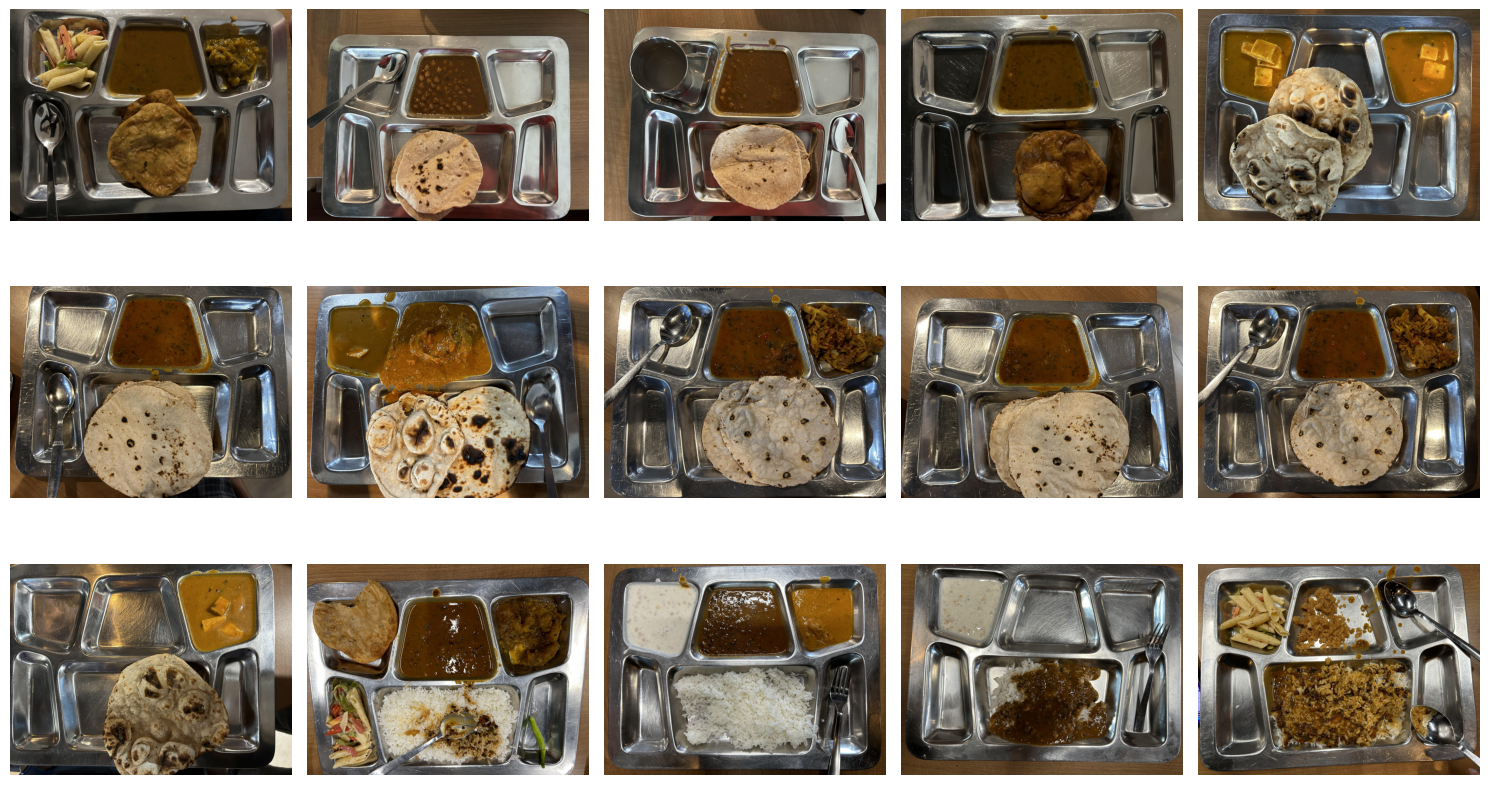

In [8]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Directory containing images
image_directory = '/content/drive/MyDrive/MLPR Project/Data/rotated_data_OD'

# Get list of image file names
image_files = [f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg', '.jpeg'))][31:46]

# Create a grid for displaying images
fig, axes = plt.subplots(3, 5, figsize=(15, 9))  # Adjust the size as needed
axes = axes.flatten()

# Load and display each image
for ax, img_file in zip(axes, image_files):
    img_path = os.path.join(image_directory, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide the axes

plt.tight_layout()
plt.show()

In [4]:
# data_dir = "/content/drive/MyDrive/MLPR Project/cropped"

In [5]:
# Load the dataset
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/MLPR Project/Data/final_cropped")
# print(type(dataset))

# Test-Train Split
train_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.2])

In [6]:
len(dataset.classes)

45

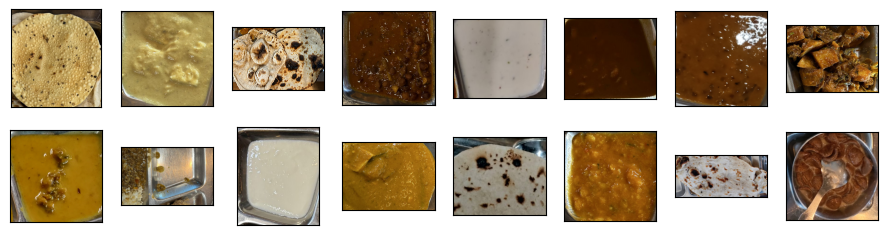

In [7]:
sample1 = [train_data[i][0] for i in range(8)]
sample2 = [train_data[-i - 1][0] for i in range(8)]
d2l.show_images(sample1 + sample2, 2, 8, scale=1.4);

In [8]:
# Specify the means and standard deviations of the three RGB channels to
# standardize each channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256, 256]),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

In [9]:
# Apply different transformations for train and test sets
train_data.dataset.transform = train_augs
test_data.dataset.transform = test_augs

In [10]:
train_data[1]

(tensor([[[ 0.2282,  0.1426,  0.1939,  ...,  0.6563,  0.7248,  0.6734],
          [ 0.2111,  0.2453,  0.2282,  ...,  0.6906,  0.7762,  0.7419],
          [ 0.2453,  0.2796,  0.2282,  ...,  0.6563,  0.7591,  0.7419],
          ...,
          [-0.3198, -0.2856, -0.2513,  ..., -0.0629, -0.0458,  0.3823],
          [-0.4226, -0.3883, -0.3198,  ..., -0.1314, -0.0458,  0.5364],
          [-0.4397, -0.3883, -0.3541,  ..., -0.1143,  0.0227,  0.5536]],
 
         [[ 0.0651, -0.0399, -0.0224,  ...,  0.4328,  0.5028,  0.4503],
          [ 0.0651,  0.0476, -0.0049,  ...,  0.4853,  0.5903,  0.5553],
          [ 0.1001,  0.0651, -0.0049,  ...,  0.4678,  0.5728,  0.5553],
          ...,
          [-0.4776, -0.4601, -0.4251,  ..., -0.2500, -0.2500,  0.2402],
          [-0.5651, -0.5476, -0.4776,  ..., -0.3200, -0.2150,  0.4153],
          [-0.5476, -0.5126, -0.4951,  ..., -0.2675, -0.0924,  0.4853]],
 
         [[-0.6193, -0.7064, -0.6890,  ..., -0.4798, -0.4101, -0.4624],
          [-0.6193, -0.6367,

In [11]:
print(type(train_data))

<class 'torch.utils.data.dataset.Subset'>


In [12]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [14]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 45)
nn.init.xavier_uniform_(finetune_net.fc.weight);

In [15]:
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(net, learning_rate, batch_size=32, num_epochs=10,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_data, batch_size=batch_size)
    # print(len(train_iter))
    # print(test_iter)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

loss 0.022, train acc 0.994, test acc 0.754
236.7 examples/sec on [device(type='cuda', index=0)]


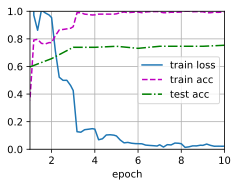

In [16]:
train_fine_tuning(finetune_net, 5e-4)

In [17]:
# Save the model
torch.save(finetune_net.state_dict(), 'finetune_model_new.pth')

In [18]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms.functional as TF

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


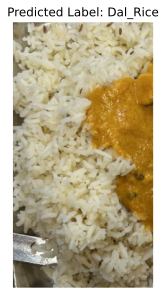

In [19]:
# Load the model
loaded_model = torchvision.models.resnet18(pretrained=False)
loaded_model.fc = nn.Linear(loaded_model.fc.in_features, 45)
loaded_model.load_state_dict(torch.load('finetune_model_new.pth'))
loaded_model.eval()

# Load and preprocess a single image
single_image_path = "/content/drive/MyDrive/MLPR Project/Data/cropped/Rice/88_Rice.png"
image = torchvision.io.read_image(single_image_path)
image = image.float() / 255.0  # Convert to float and normalize to [0, 1]
image = normalize(image)  # Apply normalization
image = image.unsqueeze(0)  # Add batch dimension

# Make prediction
with torch.no_grad():
    output = loaded_model(image)

# Get predicted class
predicted_class = torch.argmax(output).item()

# Get label from dataset
label = dataset.classes[predicted_class]

img = mpimg.imread(single_image_path)
plt.imshow(img)
plt.title(f"Predicted Label: {label}")
plt.axis("off")
plt.show()